# LAb -3-: Bag of Visual Words(BoVW) for Image Classification

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
image_dir = r"C:\Users\moham\OneDrive\Desktop\3CS IASD\Computer-Vision\lab3\UCMerced_LandUse\Images" 
class_names = [
    "agricultural", "airplane", "baseballdiamond", "beach", "buildings",
    "chaparral", "denseresidential", "forest", "freeway", "golfcourse",
    "harbor", "intersection", "mediumresidential", "mobilehomepark", "overpass",
    "parkinglot", "river", "runway", "sparseresidential", "storagetanks",
    "tenniscourt"
]

images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(image_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            if image_file.endswith(".tif"):
                image_path = os.path.join(class_dir, image_file)
                try:
                    img = cv2.imread(image_path)
                    if img is not None:
                        # Resize images to a consistent size if there are variations:
                        img = cv2.resize(img, (256, 256))  # Ensure all images are 256x256

                        images.append(img)
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error loading or resizing image {image_path}: {e}")



# Convert to NumPy arrays (after ensuring consistent sizes)
images = np.array(images)
labels = np.array(labels)

In [3]:
labels

array(['agricultural', 'agricultural', 'agricultural', ..., 'tenniscourt',
       'tenniscourt', 'tenniscourt'], dtype='<U17')

## Labels Encoding

In [4]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [5]:
labels_encoded

array([ 0,  0,  0, ..., 20, 20, 20], dtype=int64)

## Data Splitting

In [6]:
# Split the data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of testing images: {X_test.shape[0]}")

Number of training images: 1680
Number of testing images: 420


## SIFT Feature Extraction

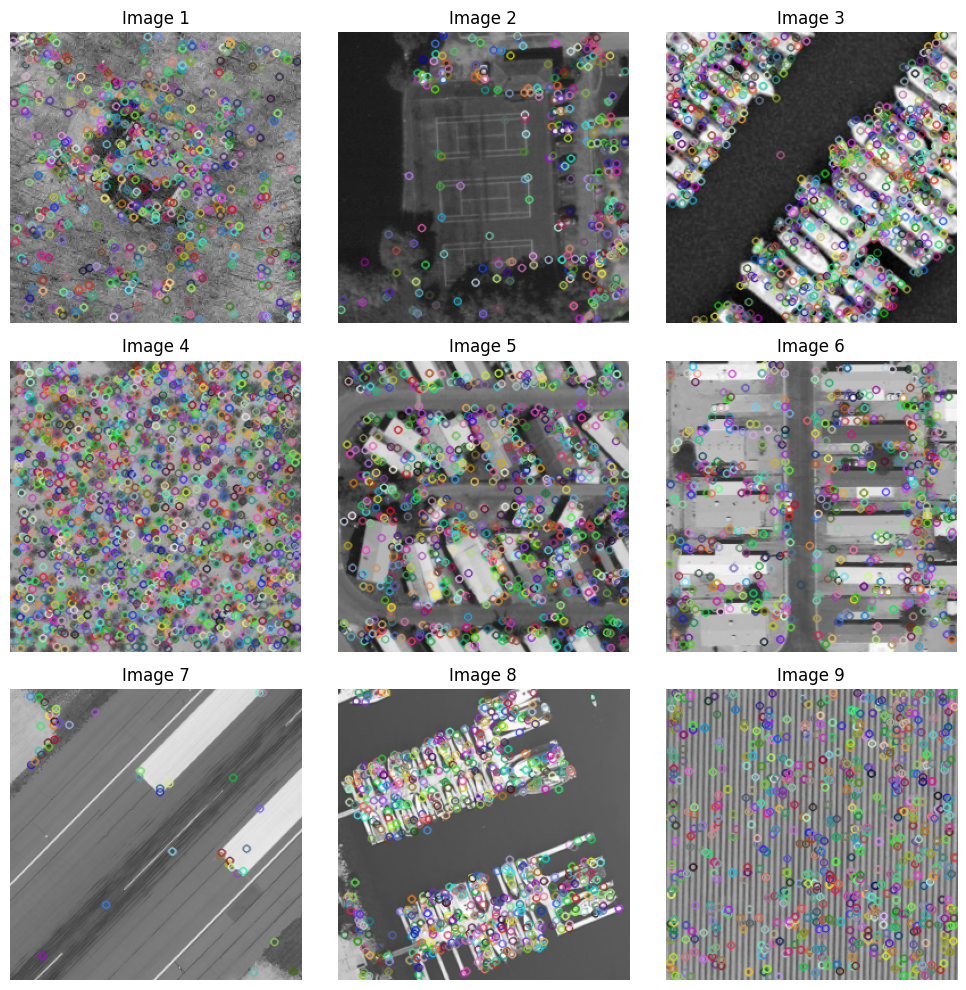

Processed 1680 images, displayed 9 of them in a 3x3 grid.


In [7]:
descriptors = []

display_count = 0
display_limit = 9  # Display only the first 9 images

# Prepare a 3x3 grid for displaying images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for image in X_train:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize the SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray, None)
    
    # Append descriptors for later use
    if des is not None:
        descriptors.append(des)
    
    # Display the first 9 images with keypoints
    if display_count < display_limit:
        # Draw keypoints on the image
        img_with_keypoints = cv2.drawKeypoints(gray, kp, None)

        # Display the image in the grid
        ax = axes[display_count // 3, display_count % 3]  # Calculate row, column
        ax.imshow(img_with_keypoints, cmap='gray')
        ax.set_title(f"Image {display_count + 1}")
        ax.axis('off')  # Hide axes for a cleaner look
        
        display_count += 1
    
    # Stop processing further images once 9 are displayed
    if display_count >= display_limit:
        break

# Adjust layout and display the 3x3 grid of images
plt.tight_layout()
plt.show()

print(f"Processed {len(X_train)} images, displayed {display_count} of them in a 3x3 grid.")

In [8]:
print(f"Number of descriptors: {len(descriptors)}")

Number of descriptors: 9


## Vocabulary Creation (K-Means)

In [9]:
num_clusters = 100

# Stack all descriptors into a single array for clustering
all_descriptors = np.vstack(descriptors)
print("Descriptors shape:", all_descriptors.shape)
print('len of descriptors:', len(all_descriptors))

# Step 2: Build the Visual Vocabulary using K-means Clustering
print("Clustering descriptors to create visual vocabulary...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_  # Each center is a visual word

print("Visual vocabulary created with", num_clusters, "words.")


Descriptors shape: (6997, 128)
len of descriptors: 6997
Clustering descriptors to create visual vocabulary...


c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visual vocabulary created with 100 words.


## Histogram Representation
### Create histograms of visual words for each training image

In [10]:
X_train_histograms = []
for image in X_train:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, des = sift.detectAndCompute(gray, None)
    histogram = np.zeros(num_clusters)
    if des is not None:
        word_indices = kmeans.predict(des)
        for word_index in word_indices:
            histogram[word_index] += 1
    X_train_histograms.append(histogram)

KeyboardInterrupt: 

## Normalization (L2 normalization)

In [ ]:
X_train_histograms = normalize(X_train_histograms, norm='l2')  # L2 normalization

## Classifier Training (Support Vector Machine)

In [ ]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_histograms, y_train)

SVC(kernel='linear', random_state=42)

## Generate Predictions for Test Images & Normalization

In [ ]:
X_test_histograms = []
for image in X_test:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, des = sift.detectAndCompute(gray, None)
    histogram = np.zeros(num_clusters)
    if des is not None:
        word_indices = kmeans.predict(des)
        for word_index in word_indices:
            histogram[word_index] += 1
    X_test_histograms.append(histogram)

X_test_histograms = normalize(X_test_histograms, norm='l2') 

KeyboardInterrupt: 

## Predict classes for test images

In [ ]:
y_pred = svm.predict(X_test_histograms)

## Performance Evaluation
### Calculate accuracy

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


### Compute and display confusion matrix

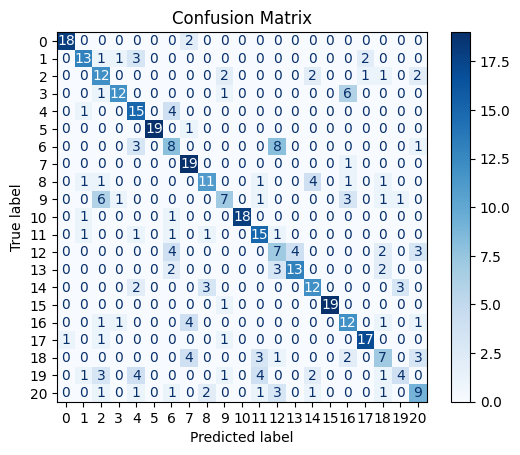

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=range(21)).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Testing with 100 clusters...


c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visual vocabulary created with 100 words.
Accuracy with 100 clusters: 0.64


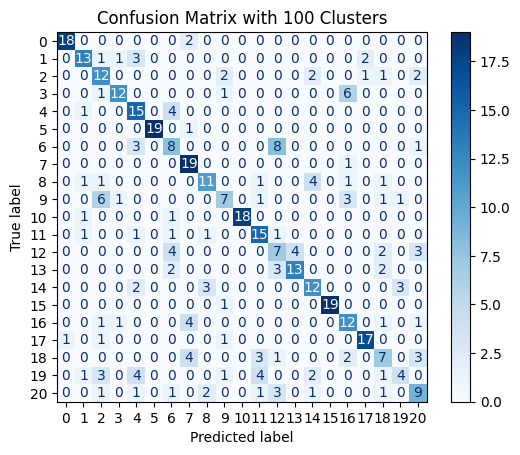

Testing with 200 clusters...


c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visual vocabulary created with 200 words.
Accuracy with 200 clusters: 0.65


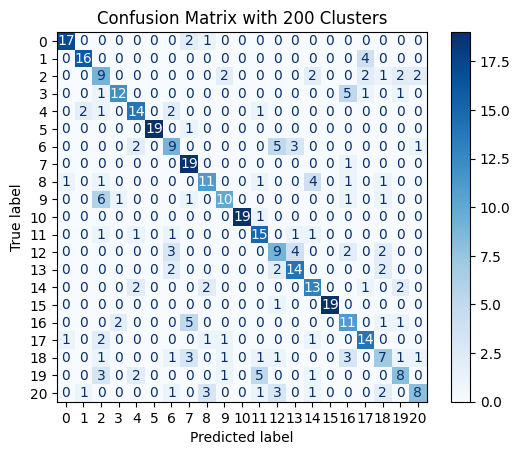

Testing with 500 clusters...


c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visual vocabulary created with 500 words.
Accuracy with 500 clusters: 0.70


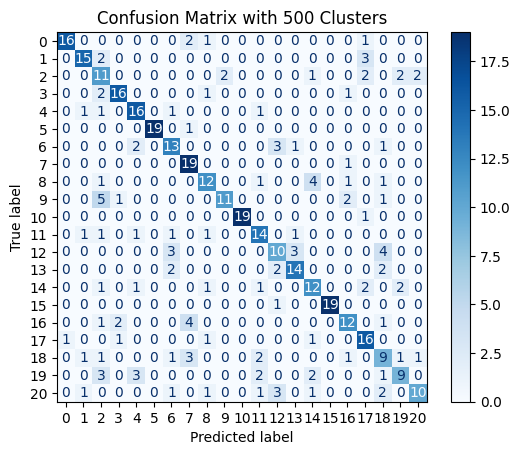

In [ ]:
def test_with_different_clusters(X_train, y_train, X_test, y_test, descriptors, cluster_values):
    for n_clusters in cluster_values:
        print(f"Testing with {n_clusters} clusters...")

        # Step 1: Build the Visual Vocabulary using K-means Clustering
        all_descriptors = np.vstack(descriptors)  # Stack all descriptors for clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(all_descriptors)
        visual_words = kmeans.cluster_centers_
        print(f"Visual vocabulary created with {n_clusters} words.")

        # Step 2: Create histograms of visual words for each training image
        X_train_histograms = []
        sift = cv2.SIFT_create()  # Initialize SIFT
        for image in X_train:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, des = sift.detectAndCompute(gray, None)
            histogram = np.zeros(n_clusters)
            if des is not None:
                word_indices = kmeans.predict(des)
                for word_index in word_indices:
                    histogram[word_index] += 1
            X_train_histograms.append(histogram)
        
        # L2 Normalization for histograms
        X_train_histograms = normalize(X_train_histograms, norm='l2')

        # Step 3: Train the SVM Classifier
        svm = SVC(kernel='linear', random_state=42)
        svm.fit(X_train_histograms, y_train)

        # Step 4: Create histograms of visual words for each test image
        X_test_histograms = []
        for image in X_test:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, des = sift.detectAndCompute(gray, None)
            histogram = np.zeros(n_clusters)
            if des is not None:
                word_indices = kmeans.predict(des)
                for word_index in word_indices:
                    histogram[word_index] += 1
            X_test_histograms.append(histogram)
        
        # L2 Normalization for test histograms
        X_test_histograms = normalize(X_test_histograms, norm='l2')

        # Step 5: Make Predictions and Evaluate
        y_pred = svm.predict(X_test_histograms)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy with {n_clusters} clusters: {accuracy:.2f}")

        # Step 6: Display Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(y_test)))).plot(cmap='Blues')
        plt.title(f"Confusion Matrix with {n_clusters} Clusters")
        plt.show()

# Example usage:
cluster_values = [100, 200, 500]
test_with_different_clusters(X_train, y_train, X_test, y_test, descriptors, cluster_values)